In [2]:
import pandas as pd
import numpy as np

# --- paths (edit if needed) ---
PATH_IGAB = "results_backbone_fvnoh3fit.csv"          # IGFold + ABodyBuilder2 results
PATH_AF3  = "results_af3_backbone_fvnoh3fit.csv"      # AF3 RMSD results
PATH_AF3_SUMMARY = "af3_summary.csv"                  # AF3 ranking_score/ptm/iptm + model file

def norm_id(s):
    return s.astype(str).str.strip().str.upper()

def base_id_from_any(x: pd.Series) -> pd.Series:
    # handles 7UM3_2 -> 7UM3, also safe for plain 7UM3
    return norm_id(x).str.split("_").str[0]

igab = pd.read_csv(PATH_IGAB)
af3r = pd.read_csv(PATH_AF3)
af3s = pd.read_csv(PATH_AF3_SUMMARY)

# normalize IDs
igab["id_norm"] = norm_id(igab["id"])
igab["base_pdb_id"] = base_id_from_any(igab["id_norm"])

af3r["id_norm"] = norm_id(af3r["id"])
af3r["base_pdb_id"] = base_id_from_any(af3r["id_norm"])

# af3_summary.csv uses pdb_id as folder name
af3s["id_norm"] = norm_id(af3s["pdb_id"])
af3s["base_pdb_id"] = base_id_from_any(af3s["id_norm"])

# numeric coercions (safe)
num_cols = ["rmsd_fv_noh3_ctx","rmsd_fv_all_ctx","rmsd_h3_ctx","rmsd_h3_local",
            "pred_conf_h3_bfac_mean","pred_conf_fv_bfac_mean","n_h3_atoms","n_fit_atoms","n_chains_used"]
for c in num_cols:
    if c in igab.columns:
        igab[c] = pd.to_numeric(igab[c], errors="coerce")
    if c in af3r.columns:
        af3r[c] = pd.to_numeric(af3r[c], errors="coerce")

print("Loaded:")
print(" igab:", igab.shape, "methods:", igab["method"].unique())
print(" af3r:", af3r.shape, "methods:", af3r["method"].unique())
print(" af3s:", af3s.shape, "cols:", [c for c in ["pdb_id","best_model","best_score","ranking_score","ptm","iptm","model_cif"] if c in af3s.columns])

Loaded:
 igab: (1388, 20) methods: ['IGFold' 'ABodyBuilder2']
 af3r: (55, 20) methods: ['AlphaFold3']
 af3s: (49, 11) cols: ['pdb_id', 'best_model', 'best_score', 'ranking_score', 'ptm', 'iptm', 'model_cif']


In [3]:
# Keep only the main AF3 metrics we care about
af3s_keep = af3s[[c for c in ["id_norm","base_pdb_id","best_model","best_score","ranking_score","ptm","iptm","model_cif","summary_json"] if c in af3s.columns]].copy()

# AF3 RMSD results -> attach AF3 summary (ranking_score/ptm/iptm)
af3_merged = af3r.merge(
    af3s_keep,
    on=["id_norm","base_pdb_id"],
    how="left",
    suffixes=("","_sum"),
)

# Combine IG/AB + AF3 into one long table
common_cols = [
    "id", "id_norm", "base_pdb_id", "method", "label",
    "ref_pdb", "pred_pdb",
    "rmsd_fv_noh3_ctx", "rmsd_fv_all_ctx", "rmsd_h3_ctx", "rmsd_h3_local",
    "pred_conf_h3_bfac_mean", "pred_conf_fv_bfac_mean",
    "h3_seq", "n_h3_atoms", "n_fit_atoms", "n_chains_used",
    "chain_map", "chain_identities", "error",
]

igab_view = igab[[c for c in common_cols if c in igab.columns]].copy()
af3_view  = af3_merged[[c for c in common_cols if c in af3_merged.columns] + 
                      [c for c in ["best_model","best_score","ranking_score","ptm","iptm","model_cif"] if c in af3_merged.columns]].copy()

all_methods = pd.concat([igab_view, af3_view], ignore_index=True)

print("Combined table:", all_methods.shape)
print("Methods:", all_methods["method"].value_counts(dropna=False).to_dict())

Combined table: (1443, 26)
Methods: {'IGFold': 698, 'ABodyBuilder2': 690, 'AlphaFold3': 55}


In [4]:
def interpret_ctx_vs_local(ctx, local, *, ctx_hi=6.0, local_hi=3.0):
    """
    A simple, defensible interpretation:
    - local high => loop-shape is hard
    - ctx much higher than local => placement/orientation dominates
    """
    if not np.isfinite(ctx) or not np.isfinite(local):
        return "RMSD missing (mapping/atoms too few or excluded)."
    if local >= local_hi and ctx >= ctx_hi:
        return "Likely intrinsic H3 loop-shape difficulty (both local + context are high)."
    if (ctx - local) >= 3.0 and ctx >= ctx_hi:
        return "Likely placement/orientation issue (context >> local; loop shape relatively better than placement)."
    if local < local_hi and ctx < ctx_hi:
        return "H3 is reasonably accurate (both local + context are low/moderate)."
    if local >= local_hi and ctx < ctx_hi:
        return "Odd pattern: loop shape looks hard but placement ok (check mapping / anchors / numbering)."
    return "Mixed/medium difficulty; inspect structure + chain mapping."

In [5]:
def show_target(target_id: str):
    tid = target_id.strip().upper()
    base = tid.split("_")[0]

    d = all_methods[all_methods["base_pdb_id"] == base].copy()
    if d.empty:
        print(f"No rows found for base_pdb_id={base}")
        return

    # Prefer AF3 rows that match exact folder id if user provided suffix (e.g., 7UM3_2)
    if "_" in tid:
        d_af3 = d[(d["method"] == "AlphaFold3") & (d["id_norm"] == tid)]
        if not d_af3.empty:
            d = pd.concat([d[d["method"] != "AlphaFold3"], d_af3], ignore_index=True)

    # Keep one row per method (if duplicates exist, pick the first)
    d = d.sort_values(["method","id_norm"]).drop_duplicates(subset=["method"], keep="first")

    cols = [
        "method","id","label",
        "rmsd_fv_noh3_ctx","rmsd_fv_all_ctx","rmsd_h3_ctx","rmsd_h3_local",
        "pred_conf_h3_bfac_mean","pred_conf_fv_bfac_mean",
        "best_model","ranking_score","ptm","iptm",
        "chain_map","error",
        "h3_seq","n_h3_atoms"
    ]
    cols = [c for c in cols if c in d.columns]

    # Print the comparison table
    disp = d[cols].copy()
    # nicer formatting
    for c in ["rmsd_fv_noh3_ctx","rmsd_fv_all_ctx","rmsd_h3_ctx","rmsd_h3_local","ranking_score","ptm","iptm"]:
        if c in disp.columns:
            disp[c] = pd.to_numeric(disp[c], errors="coerce").map(lambda x: round(x, 3) if np.isfinite(x) else x)

    print(f"=== Target base PDB: {base} ===")
    display(disp)

    # Interpret each method’s ctx vs local behavior
    print("\nInterpretation (ctx vs local):")
    for _, r in d.iterrows():
        ctx = r.get("rmsd_h3_ctx", np.nan)
        local = r.get("rmsd_h3_local", np.nan)
        print(f"- {r['method']}: {interpret_ctx_vs_local(ctx, local)}")

# Example usage:
# show_target("7SJS")
# show_target("7UM3")      # base id
# show_target("7UM3_2")    # specific AF3 replicate folder (if present)

In [9]:
show_target("7SJS")

=== Target base PDB: 7SJS ===


,method,id,label,rmsd_fv_noh3_ctx,rmsd_fv_all_ctx,rmsd_h3_ctx,rmsd_h3_local,pred_conf_h3_bfac_mean,pred_conf_fv_bfac_mean,best_model,ranking_score,ptm,iptm,chain_map,error,h3_seq,n_h3_atoms
1019,ABodyBuilder2,7SJS_HL,7SJS_HL,0.585,0.643,1.726,0.636,1.346667,0.297729,NaN,NaN,NaN,NaN,H->H;L->L,NaN,TMAPVV,24.0
1390,AlphaFold3,7SJS,af3_best_model_0,1.988,2.062,3.881,1.828,59.257500,89.300855,0.0,0.52,0.69,0.47,H->A;L->B,NaN,TMAPVV,24.0
324,IGFold,7SJS_HL,7SJS_HL,1.184,1.384,4.520,2.070,0.595000,0.342943,NaN,NaN,NaN,NaN,H->H;L->L,NaN,TMAPVV,24.0



Interpretation (ctx vs local):
- ABodyBuilder2: H3 is reasonably accurate (both local + context are low/moderate).
- AlphaFold3: H3 is reasonably accurate (both local + context are low/moderate).
- IGFold: H3 is reasonably accurate (both local + context are low/moderate).


In [7]:
import pandas as pd
import numpy as np

R_IGAB = "results_backbone_fvnoh3fit.csv"
R_AF3  = "results_af3_backbone_fvnoh3fit.csv"

igab = pd.read_csv(R_IGAB)
af3  = pd.read_csv(R_AF3)

def base_id(s):
    return s.astype(str).str.strip().str.upper().str.split("_").str[0]

igab["base_pdb_id"] = base_id(igab["id"])
af3["base_pdb_id"]  = base_id(af3["id"])

# numeric
for c in ["rmsd_h3_ctx","rmsd_h3_local","rmsd_fv_noh3_ctx","rmsd_fv_all_ctx"]:
    if c in igab.columns: igab[c] = pd.to_numeric(igab[c], errors="coerce")
    if c in af3.columns:  af3[c]  = pd.to_numeric(af3[c], errors="coerce")

# keep only successful rows (no errors) if error column exists
if "error" in igab.columns:
    igab_ok = igab[igab["error"].fillna("").astype(str).str.strip() == ""].copy()
else:
    igab_ok = igab.copy()

# pivot IgFold vs AB2
pv = igab_ok.pivot_table(index="base_pdb_id", columns="method", values="rmsd_h3_ctx", aggfunc="first")

# require both methods present
pv = pv.dropna(subset=["IGFold","ABodyBuilder2"], how="any").copy()
pv["delta_abs"] = (pv["ABodyBuilder2"] - pv["IGFold"]).abs()
pv["delta_signed"] = (pv["ABodyBuilder2"] - pv["IGFold"])

delta_tbl = pv.reset_index().sort_values("delta_abs", ascending=False)
delta_tbl.head(10)

method,base_pdb_id,ABodyBuilder2,IGFold,delta_abs,delta_signed
497,9GP2,8.820386,3.034516,5.785870,5.785870
35,7SL5,12.891693,7.902927,4.988766,4.988766
442,9BDI,8.638313,3.857547,4.780766,4.780766
61,7TTM,6.581204,2.729680,3.851524,3.851524
521,9ML8,10.169141,6.520046,3.649095,3.649095
344,8T9Y,3.147281,6.778035,3.630754,-3.630754
522,9ML9,6.932764,3.351221,3.581543,3.581543
333,8SIT,6.461388,2.989526,3.471862,3.471862
283,8HRD,5.652535,2.196168,3.456367,3.456367
50,7T7B,6.505959,3.049807,3.456152,3.456152


In [8]:
DELTA_CUTOFF = 2.0

sel = delta_tbl[delta_tbl["delta_abs"] >= DELTA_CUTOFF].copy()

# AF3: choose best AF3 per target by (lowest H3_ctx). If you prefer local, change to rmsd_h3_local.
if "error" in af3.columns:
    af3_ok = af3[af3["error"].fillna("").astype(str).str.strip() == ""].copy()
else:
    af3_ok = af3.copy()

af3_best = af3_ok.sort_values("rmsd_h3_ctx").groupby("base_pdb_id", as_index=False).first()
af3_best = af3_best[["base_pdb_id","id","pred_pdb","rmsd_h3_ctx","rmsd_h3_local","rmsd_fv_noh3_ctx","rmsd_fv_all_ctx"]].copy()
af3_best = af3_best.rename(columns={
    "id":"af3_id",
    "pred_pdb":"af3_pred",
    "rmsd_h3_ctx":"af3_h3_ctx",
    "rmsd_h3_local":"af3_h3_local",
    "rmsd_fv_noh3_ctx":"af3_fv_noh3_ctx",
    "rmsd_fv_all_ctx":"af3_fv_all_ctx",
})

sel = sel.merge(af3_best, on="base_pdb_id", how="left")

print("n delta>=2:", len(sel))
sel.sort_values("delta_abs", ascending=False).head(40)

n delta>=2: 40


,base_pdb_id,ABodyBuilder2,IGFold,delta_abs,delta_signed,af3_id,af3_pred,af3_h3_ctx,af3_h3_local,af3_fv_noh3_ctx,af3_fv_all_ctx
0,9GP2,8.820386,3.034516,5.785870,5.785870,9GP2,af3_output_pdb/9gp2/fold_9gp2_model_0.pdb,1.872975,1.344418,0.887079,0.958524
1,7SL5,12.891693,7.902927,4.988766,4.988766,7SL5,af3_output_pdb/7sl5/fold_7sl5_model_0.pdb,10.033195,3.345610,0.931789,3.236063
2,9BDI,8.638313,3.857547,4.780766,4.780766,9BDI,af3_output_pdb/9bdi/fold_9bdi_model_0.pdb,3.370812,0.862255,0.554973,1.112175
3,7TTM,6.581204,2.729680,3.851524,3.851524,7TTM,af3_output_pdb/7ttm/fold_7ttm_model_0.pdb,4.643055,1.556689,0.740228,1.516170
4,9ML8,10.169141,6.520046,3.649095,3.649095,9ML8,af3_output_pdb/9ml8/fold_9ml8_model_0.pdb,1.900328,0.783667,2.374316,2.343899
5,8T9Y,3.147281,6.778035,3.630754,-3.630754,8T9Y,af3_output_pdb/8t9y/fold_8t9y_model_0.pdb,5.745231,4.395714,1.283230,2.072424
6,9ML9,6.932764,3.351221,3.581543,3.581543,9ML9,af3_output_pdb/9ml9/fold_9ml9_model_0.pdb,0.640337,0.465056,0.631488,0.632274
7,8SIT,6.461388,2.989526,3.471862,3.471862,8SIT_2,af3_output_pdb/8sit_2/fold_8sit_model_0.pdb,2.837694,1.732381,0.944952,1.213175
8,8HRD,5.652535,2.196168,3.456367,3.456367,8HRD,af3_output_pdb/8hrd/fold_8hrd_model_0.pdb,4.301584,0.899998,0.697309,1.366124
9,7T7B,6.505959,3.049807,3.456152,3.456152,7T7B,af3_output_pdb/7t7b/fold_7t7b_model_0.pdb,5.909880,3.304038,0.615023,1.821687


In [8]:
def show_case(base_pdb_id: str):
    base_pdb_id = str(base_pdb_id).strip().upper()
    d = igab.copy()
    d["base_pdb_id"] = d["id"].astype(str).str.strip().str.upper().str.split("_").str[0]
    dd = d[d["base_pdb_id"] == base_pdb_id].copy()
    if "error" in dd.columns:
        dd_ok = dd[dd["error"].fillna("").astype(str).str.strip() == ""].copy()
    else:
        dd_ok = dd.copy()

    cols = ["method","id","pred_pdb","ref_pdb","rmsd_fv_noh3_ctx","rmsd_fv_all_ctx","rmsd_h3_ctx","rmsd_h3_local","chain_map","chain_identities","error"]
    cols = [c for c in cols if c in dd_ok.columns]
    print("IGFold/AB2:")
    display(dd_ok[cols].sort_values("method"))

    a = af3.copy()
    a["base_pdb_id"] = a["id"].astype(str).str.strip().str.upper().str.split("_").str[0]
    aa = a[a["base_pdb_id"] == base_pdb_id].copy()
    if "error" in aa.columns:
        aa = aa[aa["error"].fillna("").astype(str).str.strip() == ""].copy()

    cols2 = ["method","id","pred_pdb","ref_pdb","rmsd_fv_noh3_ctx","rmsd_fv_all_ctx","rmsd_h3_ctx","rmsd_h3_local","chain_map","chain_identities","error"]
    cols2 = [c for c in cols2 if c in aa.columns]
    print("AlphaFold3:")
    display(aa[cols2].sort_values("rmsd_h3_ctx"))

# Example: use the base_pdb_id from the 'good' or 'bad' table above
# show_case(good["base_pdb_id"].iloc[0])
# show_case(bad["base_pdb_id"].iloc[0])

In [9]:
import pandas as pd
import numpy as np

# assumes you already built 'sel' like you showed (delta>=2 merged with af3_best)
# and you still have the original igab dataframe loaded (results_backbone_fvnoh3fit.csv)

def interpret(ctx, local):
    if not np.isfinite(ctx) or not np.isfinite(local):
        return "missing RMSD (mapping/atoms issue)"
    if (ctx - local) >= 3.0:
        return "placement/orientation dominates (context >> local)"
    if local >= 3.0 and ctx >= 6.0:
        return "intrinsic loop-shape difficulty (both high)"
    if ctx <= 2.0 and local <= 2.0:
        return "easy (both low)"
    return "mixed/medium; inspect structure"

def case_card(base_pdb_id):
    base = str(base_pdb_id).strip().upper()
    print("="*80)
    print("TARGET:", base)

    # show the delta + AF3 row
    row = sel[sel["base_pdb_id"] == base]
    if row.empty:
        print("Not found in sel.")
        return
    display(row[["base_pdb_id","ABodyBuilder2","IGFold","delta_abs","delta_signed",
                 "af3_id","af3_h3_ctx","af3_h3_local","af3_fv_noh3_ctx","af3_fv_all_ctx"]])

    # show the raw method rows (IGFold/AB2)
    d = igab.copy()
    d["base_pdb_id"] = d["id"].astype(str).str.strip().str.upper().str.split("_").str[0]
    dd = d[d["base_pdb_id"] == base].copy()
    if "error" in dd.columns:
        dd = dd[dd["error"].fillna("").astype(str).str.strip() == ""]
    cols = ["method","id","pred_pdb","ref_pdb","rmsd_fv_noh3_ctx","rmsd_fv_all_ctx","rmsd_h3_ctx","rmsd_h3_local",
            "chain_map","chain_identities"]
    cols = [c for c in cols if c in dd.columns]
    display(dd[cols].sort_values("method"))

    # interpretation
    af3_ctx = float(row["af3_h3_ctx"].iloc[0])
    af3_loc = float(row["af3_h3_local"].iloc[0])
    print("AF3 interpretation:", interpret(af3_ctx, af3_loc))

for t in ["9GP2","7SL5","9BDI"]:
    case_card(t)

TARGET: 9GP2


,base_pdb_id,ABodyBuilder2,IGFold,delta_abs,delta_signed,af3_id,af3_h3_ctx,af3_h3_local,af3_fv_noh3_ctx,af3_fv_all_ctx
0,9GP2,8.820386,3.034516,5.78587,5.78587,9GP2,1.872975,1.344418,0.887079,0.958524


,method,id,pred_pdb,ref_pdb,rmsd_fv_noh3_ctx,rmsd_fv_all_ctx,rmsd_h3_ctx,rmsd_h3_local,chain_map,chain_identities
1322,ABodyBuilder2,9GP2_HL,/Users/tinaganjipour/Documents/UMCU/2. The pro...,/Users/tinaganjipour/Documents/UMCU/2. The pro...,0.996877,2.171546,8.820386,2.794877,H->H;L->L,"H->H:ident=1.000,aln=120,refcov=1.00,predcov=1..."
631,IGFold,9GP2_HL,/Users/tinaganjipour/Documents/UMCU/2. The pro...,/Users/tinaganjipour/Documents/UMCU/2. The pro...,1.074690,1.243064,3.034516,1.296421,H->H;L->L,"H->H:ident=1.000,aln=120,refcov=1.00,predcov=1..."


AF3 interpretation: easy (both low)
TARGET: 7SL5


,base_pdb_id,ABodyBuilder2,IGFold,delta_abs,delta_signed,af3_id,af3_h3_ctx,af3_h3_local,af3_fv_noh3_ctx,af3_fv_all_ctx
1,7SL5,12.891693,7.902927,4.988766,4.988766,7SL5,10.033195,3.34561,0.931789,3.236063


,method,id,pred_pdb,ref_pdb,rmsd_fv_noh3_ctx,rmsd_fv_all_ctx,rmsd_h3_ctx,rmsd_h3_local,chain_map,chain_identities
1115,ABodyBuilder2,7SL5_AB,/Users/tinaganjipour/Documents/UMCU/2. The pro...,/Users/tinaganjipour/Documents/UMCU/2. The pro...,0.952237,4.100394,12.891693,6.856882,A->H;B->L,"A->H:ident=0.954,aln=131,refcov=1.00,predcov=0..."
421,IGFold,7SL5_AB,/Users/tinaganjipour/Documents/UMCU/2. The pro...,/Users/tinaganjipour/Documents/UMCU/2. The pro...,0.794907,2.565444,7.902927,4.851376,A->H;B->L,"A->H:ident=1.000,aln=131,refcov=1.00,predcov=0..."


AF3 interpretation: placement/orientation dominates (context >> local)
TARGET: 9BDI


,base_pdb_id,ABodyBuilder2,IGFold,delta_abs,delta_signed,af3_id,af3_h3_ctx,af3_h3_local,af3_fv_noh3_ctx,af3_fv_all_ctx
2,9BDI,8.638313,3.857547,4.780766,4.780766,9BDI,3.370812,0.862255,0.554973,1.112175


,method,id,pred_pdb,ref_pdb,rmsd_fv_noh3_ctx,rmsd_fv_all_ctx,rmsd_h3_ctx,rmsd_h3_local,chain_map,chain_identities
937,ABodyBuilder2,9BDI_CD,/Users/tinaganjipour/Documents/UMCU/2. The pro...,/Users/tinaganjipour/Documents/UMCU/2. The pro...,0.732397,2.600376,8.638313,6.466633,C->H;D->L,"C->H:ident=0.954,aln=131,refcov=1.00,predcov=1..."
242,IGFold,9BDI_CD,/Users/tinaganjipour/Documents/UMCU/2. The pro...,/Users/tinaganjipour/Documents/UMCU/2. The pro...,0.688202,1.297805,3.857547,2.271925,C->H;D->L,"C->H:ident=1.000,aln=131,refcov=1.00,predcov=1..."


AF3 interpretation: mixed/medium; inspect structure


In [10]:
import numpy as np
import pandas as pd

# Basic sanity
print("Number of disagreement targets:", len(sel))

# Summary statistics
summary = sel[[
    "ABodyBuilder2",
    "IGFold",
    "af3_h3_ctx",
    "af3_h3_local"
]].astype(float).describe()

summary

Number of disagreement targets: 40


,ABodyBuilder2,IGFold,af3_h3_ctx,af3_h3_local
count,40.000000,40.000000,27.000000,27.000000
mean,5.901061,4.237213,4.868364,2.352865
std,2.404449,1.731602,3.227280,1.551187
min,0.607085,1.592827,0.505775,0.232936
25%,4.597776,3.019884,2.323765,0.949097
50%,5.942013,3.561457,4.301584,2.432734
75%,7.006145,5.517169,6.936935,3.324824
max,12.891693,8.415956,13.026114,6.060361


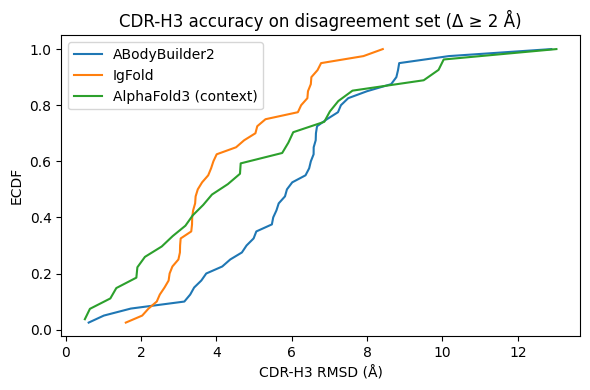

In [11]:
import matplotlib.pyplot as plt

def ecdf(x):
    x = np.sort(x[np.isfinite(x)])
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

plt.figure(figsize=(6,4))

for col, label in [
    ("ABodyBuilder2", "ABodyBuilder2"),
    ("IGFold", "IgFold"),
    ("af3_h3_ctx", "AlphaFold3 (context)"),
]:
    x, y = ecdf(sel[col].astype(float).values)
    plt.plot(x, y, label=label)

plt.xlabel("CDR-H3 RMSD (Å)")
plt.ylabel("ECDF")
plt.title("CDR-H3 accuracy on disagreement set (Δ ≥ 2 Å)")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
case_good = sel[sel["base_pdb_id"] == "9GP2"]

case_good[[
    "base_pdb_id",
    "ABodyBuilder2",
    "IGFold",
    "af3_h3_ctx",
    "af3_h3_local",
    "af3_fv_noh3_ctx",
    "af3_fv_all_ctx"
]]

,base_pdb_id,ABodyBuilder2,IGFold,af3_h3_ctx,af3_h3_local,af3_fv_noh3_ctx,af3_fv_all_ctx
0,9GP2,8.820386,3.034516,1.872975,1.344418,0.887079,0.958524


In [13]:
ctx = float(case_good["af3_h3_ctx"])
loc = float(case_good["af3_h3_local"])

print(f"AF3 H3 RMSD (context): {ctx:.2f} Å")
print(f"AF3 H3 RMSD (local):   {loc:.2f} Å")

if ctx <= 2 and loc <= 2:
    print("Interpretation: AF3 confidently resolves the disagreement.")

AF3 H3 RMSD (context): 1.87 Å
AF3 H3 RMSD (local):   1.34 Å
Interpretation: AF3 confidently resolves the disagreement.


/var/folders/j0/vl76fnl96tq_cn2kx7l63r0w0000gn/T/ipykernel_4463/2433032353.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ctx = float(case_good["af3_h3_ctx"])
/var/folders/j0/vl76fnl96tq_cn2kx7l63r0w0000gn/T/ipykernel_4463/2433032353.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  loc = float(case_good["af3_h3_local"])


In [14]:
case_fail = sel[sel["base_pdb_id"] == "7SL5"]

case_fail[[
    "base_pdb_id",
    "ABodyBuilder2",
    "IGFold",
    "af3_h3_ctx",
    "af3_h3_local",
    "af3_fv_noh3_ctx",
    "af3_fv_all_ctx"
]]

,base_pdb_id,ABodyBuilder2,IGFold,af3_h3_ctx,af3_h3_local,af3_fv_noh3_ctx,af3_fv_all_ctx
1,7SL5,12.891693,7.902927,10.033195,3.34561,0.931789,3.236063


In [15]:
ctx = float(case_fail["af3_h3_ctx"])
loc = float(case_fail["af3_h3_local"])

print(f"AF3 H3 RMSD (context): {ctx:.2f} Å")
print(f"AF3 H3 RMSD (local):   {loc:.2f} Å")

if ctx >= 6:
    print("Interpretation: AF3 also fails in context → intrinsically difficult or ambiguous target.")
elif ctx - loc >= 3:
    print("Interpretation: Loop shape reasonable, placement/orientation unstable.")

AF3 H3 RMSD (context): 10.03 Å
AF3 H3 RMSD (local):   3.35 Å
Interpretation: AF3 also fails in context → intrinsically difficult or ambiguous target.


/var/folders/j0/vl76fnl96tq_cn2kx7l63r0w0000gn/T/ipykernel_4463/2430189865.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ctx = float(case_fail["af3_h3_ctx"])
/var/folders/j0/vl76fnl96tq_cn2kx7l63r0w0000gn/T/ipykernel_4463/2430189865.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  loc = float(case_fail["af3_h3_local"])


In [16]:
import pandas as pd
import numpy as np

H3_FEATURES = "h3_features.csv"   # adjust path if needed

df = pd.read_csv(H3_FEATURES)

# --- normalize PDB ID handling ---
if "base_pdb_id" not in df.columns:
    if "id" in df.columns:
        df["base_pdb_id"] = (
            df["id"].astype(str).str.strip().str.upper().str.split("_").str[0]
        )
    elif "pdb_id" in df.columns:
        df["base_pdb_id"] = (
            df["pdb_id"].astype(str).str.strip().str.upper().str.split("_").str[0]
        )
    else:
        raise SystemExit(f"Can't derive base_pdb_id: columns are {list(df.columns)}")

df["base_pdb_id"] = df["base_pdb_id"].astype(str).str.strip().str.upper()

print("Loaded rows:", len(df))
print("Columns:", len(df.columns))
df.head(3)

Loaded rows: 1388
Columns: 59


,id,method,label,ref_pdb,pred_pdb,rmsd_fv_noh3_ctx,rmsd_fv_all_ctx,rmsd_h3_ctx,rmsd_h3_local,pred_conf_h3_bfac_mean,...,h3_frac_aromatic,h3_has_cys,h3_has_cys_pair,h3_has_glyco_motif,h3_num_unique,h3_entropy,h3_p_count,h3_p_max_run,h3_kmer3_rarity_dataset,base_pdb_id
0,7TUS_AB,IGFold,7TUS_AB,/Users/tinaganjipour/Documents/UMCU/2. The pro...,/Users/tinaganjipour/Documents/UMCU/2. The pro...,0.85036,1.006074,3.197057,1.624476,1.464286,...,0.714286,False,False,False,3,1.556657,0,0,3.389195,7TUS
1,7W7Q_AA,IGFold,7W7Q_AA,/Users/tinaganjipour/Documents/UMCU/2. The pro...,/Users/tinaganjipour/Documents/UMCU/2. The pro...,NaN,NaN,NaN,NaN,NaN,...,0.000000,False,False,False,0,0.000000,0,0,0.000000,7W7Q
2,9IY0_HL,IGFold,9IY0_HL,/Users/tinaganjipour/Documents/UMCU/2. The pro...,/Users/tinaganjipour/Documents/UMCU/2. The pro...,0.76071,0.896774,2.513370,1.632214,0.567778,...,0.222222,False,False,False,7,2.725481,2,1,3.106275,9IY0


In [17]:
def pick_one_row(group: pd.DataFrame) -> pd.Series:
    g = group.copy()
    if "h3_seq" in g.columns:
        g["h3_seq"] = g["h3_seq"].fillna("").astype(str)
        nonempty = g[g["h3_seq"].str.len() > 0]
        if len(nonempty) > 0:
            return nonempty.iloc[0]
    return g.iloc[0]

df_target = df.groupby("base_pdb_id", as_index=False).apply(pick_one_row).reset_index(drop=True)

print("Unique targets:", len(df_target))
df_target[["base_pdb_id"] + ([c for c in ["h3_seq","h3_len"] if c in df_target.columns])].head()

Unique targets: 680


/var/folders/j0/vl76fnl96tq_cn2kx7l63r0w0000gn/T/ipykernel_4463/2090297276.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_target = df.groupby("base_pdb_id", as_index=False).apply(pick_one_row).reset_index(drop=True)


,base_pdb_id,h3_seq,h3_len
0,7DF1,GYYDILTGSRPIFFDI,16
1,7FGJ,STYYSGALDY,10
2,7FJC,GGGRRLQFDYFDY,13
3,7MYT,APRIRWGSYRLKQTNFDS,18
4,7OX1,AGEGRSWYPGYYYGMDY,17


length vs RMSD

In [18]:
from scipy import stats
import pandas as pd
import numpy as np

# Ensure numeric
df_target["h3_len"] = pd.to_numeric(df_target.get("h3_len"), errors="coerce")
if "rmsd_h3_ctx" in df_target.columns:
    df_target["rmsd_h3_ctx"] = pd.to_numeric(df_target["rmsd_h3_ctx"], errors="coerce")
elif "h3_rmsd" in df_target.columns:
    df_target["rmsd_h3_ctx"] = pd.to_numeric(df_target["h3_rmsd"], errors="coerce")
else:
    raise ValueError("Need rmsd_h3_ctx or h3_rmsd in df_target for this analysis.")

d = df_target[np.isfinite(df_target["h3_len"]) & np.isfinite(df_target["rmsd_h3_ctx"])].copy()

rho, p = stats.spearmanr(d["h3_len"].to_numpy(), d["rmsd_h3_ctx"].to_numpy())

print("Spearman correlation (h3_len vs H3 RMSD):")
print("rho =", float(rho), "p =", float(p), "n =", len(d))

# Binned table (easy to show in thesis)
bins = [0, 8, 10, 12, 14, 16, 100]
labels = ["<=8", "9-10", "11-12", "13-14", "15-16", ">=17"]
d["len_bin"] = pd.cut(d["h3_len"], bins=bins, labels=labels, right=True, include_lowest=True)

tbl = (
    d.groupby("len_bin")["rmsd_h3_ctx"]
     .agg(n="count", mean="mean", median="median", q10=lambda x: np.quantile(x, 0.10), q90=lambda x: np.quantile(x, 0.90))
     .reset_index()
)

display(tbl)

Spearman correlation (h3_len vs H3 RMSD):
rho = 0.5266318750543305 p = 4.5717573862387374e-41 n = 557


/var/folders/j0/vl76fnl96tq_cn2kx7l63r0w0000gn/T/ipykernel_4463/545978875.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d.groupby("len_bin")["rmsd_h3_ctx"]


,len_bin,n,mean,median,q10,q90
0,<=8,99,2.329733,1.852560,1.067172,4.595011
1,9-10,117,2.299592,1.909122,1.205254,3.713465
2,11-12,118,3.288636,2.759459,1.573502,5.729827
3,13-14,106,3.327190,3.192439,2.124604,4.949747
4,15-16,45,4.159524,3.890226,2.428747,6.346679
5,>=17,72,5.103659,4.647699,2.631801,7.874873


In [19]:
feature_panel = [
    # size/complexity
    "h3_len", "h3_entropy", "h3_num_unique",
    # physchem
    "h3_net_charge_pH7", "h3_kd_mean", "h3_frac_hydrophobic",
    "h3_frac_gly_pro", "h3_frac_aromatic",
    # motifs / patterns
    "h3_has_cys", "h3_has_cys_pair", "h3_has_glyco_motif",
    "h3_p_count", "h3_p_max_run",
    # rarity
    "h3_kmer3_rarity_dataset",
    # optional extras (only used if present)
    "bound_state"
]

feature_panel = [c for c in feature_panel if c in df_target.columns]
print("Using features:", feature_panel)

Using features: ['h3_len', 'h3_entropy', 'h3_num_unique', 'h3_net_charge_pH7', 'h3_kd_mean', 'h3_frac_hydrophobic', 'h3_frac_gly_pro', 'h3_frac_aromatic', 'h3_has_cys', 'h3_has_cys_pair', 'h3_has_glyco_motif', 'h3_p_count', 'h3_p_max_run', 'h3_kmer3_rarity_dataset', 'bound_state']


In [20]:
def feature_card(pdb_id: str):
    pid = str(pdb_id).strip().upper()
    row = df_target[df_target["base_pdb_id"] == pid]
    if row.empty:
        raise ValueError(f"{pid} not found in df_target. Available example IDs: {df_target['base_pdb_id'].head(10).tolist()}")
    row = row.iloc[0]

    # numeric percentiles (computed over df_target)
    numeric_cols = []
    for c in feature_panel:
        if pd.api.types.is_numeric_dtype(df_target[c]) or c in [
            "h3_len","h3_entropy","h3_num_unique","h3_net_charge_pH7","h3_kd_mean","h3_frac_hydrophobic",
            "h3_frac_gly_pro","h3_frac_aromatic","h3_p_count","h3_p_max_run","h3_kmer3_rarity_dataset"
        ]:
            numeric_cols.append(c)

    # coerce numeric safely
    dist = df_target.copy()
    for c in numeric_cols:
        dist[c] = pd.to_numeric(dist[c], errors="coerce")
    vals = {c: pd.to_numeric(row.get(c, np.nan), errors="coerce") for c in numeric_cols}

    perc = {}
    for c, v in vals.items():
        x = dist[c].dropna().to_numpy(dtype=float)
        if len(x) == 0 or not np.isfinite(v):
            perc[c] = np.nan
        else:
            perc[c] = float((x < v).mean() * 100.0)

    # Print card
    print("="*90)
    print("TARGET:", pid)

    if "h3_seq" in df_target.columns:
        seq = str(row.get("h3_seq",""))
        print("H3 seq:", seq)
        print("H3 length:", len(seq))

    # display selected features + percentiles
    out_rows = []
    for c in feature_panel:
        v = row.get(c, np.nan)
        if c in perc:
            out_rows.append({"feature": c, "value": v, "percentile_vs_dataset": perc[c]})
        else:
            out_rows.append({"feature": c, "value": v, "percentile_vs_dataset": ""})

    display(pd.DataFrame(out_rows))

    # Quick “what might confuse models?” auto-notes (only if relevant)
    notes = []
    if "h3_len" in vals and np.isfinite(vals["h3_len"]) and perc.get("h3_len", np.nan) >= 90:
        notes.append("Very long H3 (top 10%) → usually harder / more conformational freedom.")
    if "h3_kmer3_rarity_dataset" in vals and np.isfinite(vals["h3_kmer3_rarity_dataset"]) and perc.get("h3_kmer3_rarity_dataset", np.nan) >= 90:
        notes.append("High 3-mer rarity (top 10%) → unusual motifs / low training-like support.")
    if "h3_has_glyco_motif" in df_target.columns and str(row.get("h3_has_glyco_motif","")) in ["1","1.0", "True", "true"]:
        notes.append("Glycosylation sequon present (N-x-S/T, x≠P) → potential glycan/contacts not modeled can affect loop.")
    if "h3_has_cys_pair" in df_target.columns and str(row.get("h3_has_cys_pair","")) in ["1","1.0", "True", "true"]:
        notes.append("≥2 cysteines → possible disulfide-bonded mini-loop / constrained geometry.")
    if "h3_p_max_run" in vals and np.isfinite(vals["h3_p_max_run"]) and vals["h3_p_max_run"] >= 2:
        notes.append("Proline run (PP or longer) → rigid kink; can destabilize learned smooth loop priors.")
    if "h3_net_charge_pH7" in vals and np.isfinite(vals["h3_net_charge_pH7"]) and abs(vals["h3_net_charge_pH7"]) >= 3:
        notes.append("High net charge magnitude → electrostatics-driven conformations; may differ bound vs unbound.")

    if notes:
        print("\nPossible confusing factors:")
        for n in notes:
            print("-", n)
    else:
        print("\nPossible confusing factors: (none flagged as extreme by these heuristics; inspect structure-specific context)")

In [21]:
feature_card("9GP2")   # AF3 resolves disagreement
feature_card("7SL5")   # AF3 also fails

TARGET: 9GP2
H3 seq: LYYDYGDAMDY
H3 length: 11


,feature,value,percentile_vs_dataset
0,h3_len,11,49.852941
1,h3_entropy,2.299896,26.764706
2,h3_num_unique,6,27.647059
3,h3_net_charge_pH7,-3.0,2.205882
4,h3_kd_mean,-0.781818,29.117647
5,h3_frac_hydrophobic,0.636364,88.382353
6,h3_frac_gly_pro,0.090909,36.470588
7,h3_frac_aromatic,0.363636,79.117647
8,h3_has_cys,False,0.0
9,h3_has_cys_pair,False,0.0



Possible confusing factors:
- High net charge magnitude → electrostatics-driven conformations; may differ bound vs unbound.
TARGET: 7SL5
H3 seq: GLDVLRFLDLSTPSGERLDAFDI
H3 length: 23


,feature,value,percentile_vs_dataset
0,h3_len,23,99.558824
1,h3_entropy,3.323143,93.088235
2,h3_num_unique,12,95.882353
3,h3_net_charge_pH7,-3.0,2.205882
4,h3_kd_mean,0.169565,85.147059
5,h3_frac_hydrophobic,0.434783,48.823529
6,h3_frac_gly_pro,0.130435,52.205882
7,h3_frac_aromatic,0.086957,24.852941
8,h3_has_cys,False,0.0
9,h3_has_cys_pair,False,0.0



Possible confusing factors:
- Very long H3 (top 10%) → usually harder / more conformational freedom.
- High net charge magnitude → electrostatics-driven conformations; may differ bound vs unbound.


In [22]:
targets = ["9GP2", "7SL5"]
pid = [t.strip().upper() for t in targets]

cols = ["base_pdb_id"] + [c for c in ["h3_seq"] + feature_panel if c in df_target.columns]
comp = df_target[df_target["base_pdb_id"].isin(pid)][cols].copy()
comp = comp.set_index("base_pdb_id")
comp

,h3_seq,h3_len,h3_entropy,h3_num_unique,h3_net_charge_pH7,h3_kd_mean,h3_frac_hydrophobic,h3_frac_gly_pro,h3_frac_aromatic,h3_has_cys,h3_has_cys_pair,h3_has_glyco_motif,h3_p_count,h3_p_max_run,h3_kmer3_rarity_dataset,bound_state
base_pdb_id,,,,,,,,,,,,,,,,
7SL5,GLDVLRFLDLSTPSGERLDAFDI,23,3.323143,12,-3.0,0.169565,0.434783,0.130435,0.086957,False,False,False,1,1,3.192689,unbound
9GP2,LYYDYGDAMDY,11,2.299896,6,-3.0,-0.781818,0.636364,0.090909,0.363636,False,False,False,0,0,2.599282,unbound
